In [1]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import time
import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython import display
import torch
import shutil
import  random
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from distutils.dir_util import copy_tree
from IPython.display import clear_output
AUTOTUNE = tf.data.AUTOTUNE

Zbog velicine dataset-a opet cemo direktno skidati podatke sa adrese https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/, da bismo izbegli upload-ovanje velike kolicine podataka na git.



In [2]:
dataset_name = "summer2winter_yosemite"

In [3]:
_URL = f'https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/summer2winter_yosemite.zip'

path_to_zip = tf.keras.utils.get_file(
    fname=f"summer2winter_yosemite.zip",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name
PATH

WindowsPath('C:/Users/grmus/.keras/datasets/summer2winter_yosemite')

Ovaj put cemo koristiti sve slike iz ponudjenog skupa podataka.

In [4]:
totalFiles = 0
totalDir = 0
for base, dirs, files in os.walk(PATH):
    print('Searching in : ',base)
    for Files in files:
        totalFiles += 1
print('Totalni broj fajlova',totalFiles)

Searching in :  C:\Users\grmus\.keras\datasets\summer2winter_yosemite
Searching in :  C:\Users\grmus\.keras\datasets\summer2winter_yosemite\testA
Searching in :  C:\Users\grmus\.keras\datasets\summer2winter_yosemite\testB
Searching in :  C:\Users\grmus\.keras\datasets\summer2winter_yosemite\trainA
Searching in :  C:\Users\grmus\.keras\datasets\summer2winter_yosemite\trainB
Totalni broj fajlova 2740


In [5]:
# Kopiranje svih direktorijuma zajedno sa sadrzajem 
def copytree(src, dst, symlinks=False, ignore=None):
    if not os.path.exists(dst):
        os.makedirs(dst)
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            copytree(s, d, symlinks, ignore)
        else:
            if not os.path.exists(d) or os.stat(s).st_mtime - os.stat(d).st_mtime > 1:
                shutil.copy2(s, d)

In [6]:
# Kopiramo citav sadrzaj dataseta summer2winter_yosemite u datasetssummer2winter_yosemite. 
copytree(PATH,'./datasets/summer2winter_yosemite/')

In [7]:
train_dirA = "./datasets/summer2winter_yosemite/trainA/"
test_dirA = "./datasets/summer2winter_yosemite/testA/"
train_dirB = "./datasets/summer2winter_yosemite/trainB/"
test_dirB = "./datasets/summer2winter_yosemite/testB/"

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

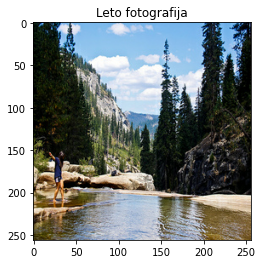

In [9]:
random_sample = random.choice(os.listdir(train_dirA))
sample_image = tf.io.read_file(train_dirA + random_sample)
sample_image = tf.io.decode_jpeg(sample_image)
plt.figure()
plt.title('Leto fotografija')
plt.imshow(sample_image)

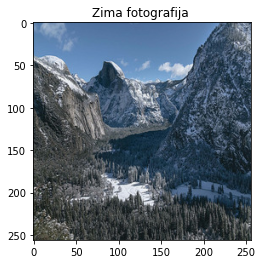

In [10]:
random_sample = random.choice(os.listdir(train_dirB))
sample_image = tf.io.read_file(train_dirB + random_sample)
sample_image = tf.io.decode_jpeg(sample_image)
plt.figure()
plt.title('Zima fotografija ')
plt.imshow(sample_image)

In [11]:
# funkcija za ucitavanje slike
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    
    

    # Prebacujemo slike  u float32 tenzore
    
    image = tf.cast(image,tf.float32)
      
    
    return image

In [12]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

In [13]:
# normalizovanje slike u opseg [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [14]:
@tf.function
def random_jitter(image):
  # Povecanje dimenzije slike  na 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Random isecanje slike sa smanjenjem dimenzije na 256 x 256 x 3
    image = random_crop(image)

    # Random okretanje slike
    image = tf.image.random_flip_left_right(image)

    return image

In [15]:
def load_image_train(image_file):
    image = load(image_file)
    jittered_image = random_jitter(image)
    normalized_image = normalize(jittered_image)

    
    return normalized_image

In [16]:
# jedina razlika izmedju load_image_test i load_image_train je sto na slike iz skupa za testiranje ne radimo nikakve promene
def load_image_test(image_file):
    image = load(image_file)
    
    image = normalize(image)

    
    return image

In [17]:
# Kreiranje skupa za treniranje. Koriscenja je funkcija load_image_train koja u sebi ima
# odsecanje slike i random rotiranje slike 
train_datasetA = tf.data.Dataset.list_files(train_dirA+"*.jpg")
train_datasetA = train_datasetA.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_datasetA = train_datasetA.shuffle(BUFFER_SIZE)
train_datasetA = train_datasetA.batch(BATCH_SIZE)

In [18]:
train_datasetB = tf.data.Dataset.list_files(train_dirB+"*.jpg")
train_datasetB = train_datasetB.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_datasetB = train_datasetB.shuffle(BUFFER_SIZE)
train_datasetB = train_datasetB.batch(BATCH_SIZE)

In [19]:
test_datasetA = tf.data.Dataset.list_files(test_dirA+"*.jpg")
test_datasetA = test_datasetA.map(load_image_test,
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_datasetA = test_datasetA.shuffle(BUFFER_SIZE)
test_datasetA = test_datasetA.batch(BATCH_SIZE)

In [20]:
test_datasetB = tf.data.Dataset.list_files(test_dirB+"*.jpg")
test_datasetB = test_datasetB.map(load_image_test,
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_datasetB = test_datasetB.shuffle(BUFFER_SIZE)
test_datasetB = test_datasetB.batch(BATCH_SIZE)

In [21]:
sample_summer = next(iter(train_datasetA))
sample_winter = next(iter(train_datasetB))

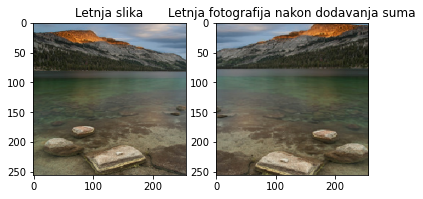

In [22]:
plt.subplot(121)
plt.title('Letnja slika')
plt.imshow(sample_summer[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Letnja fotografija nakon dodavanja suma')
plt.imshow(random_jitter(sample_summer[0]) * 0.5 + 0.5)

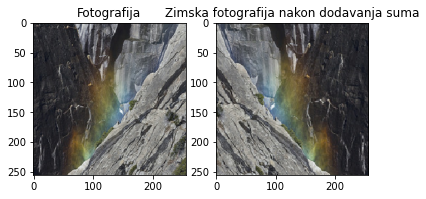

In [23]:
plt.subplot(121)
plt.title('Fotografija')
plt.imshow(sample_winter[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zimska fotografija nakon dodavanja suma')
plt.imshow(random_jitter(sample_winter[0]) * 0.5 + 0.5)

# Generator i Diskriminator

Generator je isti kao i u pix2pix primeru. Jedina razlika je sto se umesto unutrasnje standardizacije koristi se standardizacija instanci. Za CycleGan model potrebna su dva razlicita generatora odnosno dva razlicita diskriminatora. Jedan ce biti obucavan da transformise Moneove slike u fotografiju, dok ce drugi biti obucavan da transformise fotografije u Moneove slike.

-  generator G pokusava da transformise sliku X u sliku Y ( G: X->Y)
-  generator F pokusava da transformise sliku Y u sliku X ( F: Y->X)
-  diskriminator D_X uci da razlikuje slike X i generisane slike od generatora F (F(Y))
-  diskriminator D_Y uci da razlikuje slike Y i generisane slike od generatora G (G(X))


<img src="images/cyclegan.png"  width="400" hight="400" align="left">

In [24]:
OUTPUT_CHANNELS = 3

In [25]:
def downsample(filters,size,apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.,0.12)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',
                              kernel_initializer=initializer,use_bias=False))
    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [26]:
def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.12)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',
                                       kernel_initializer=initializer,
                                       use_bias=False))
    result.add(tfa.layers.InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    
    return result

In [27]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    
    down_stack= [
        downsample(64,4,apply_batchnorm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4)     
        ]
    
    up_stack = [
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4),
        upsample(256,4),
        upsample(128,4),
        upsample(64,4)        
    ]
    
    initializer = tf.random_normal_initializer(0.,0.12)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,4,
                                          strides=2,padding='same',
                                          kernel_initializer=initializer,activation='tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips =reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    
    return tf.keras.Model(inputs=inputs,outputs=x)

In [28]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.12)
    
    inp = tf.keras.layers.Input(shape=[256,256,3],name="input_image")
    
    
    
    
    down1 = downsample(64,4,False)(inp)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256,4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512,4,
                                 strides=1,
                                 kernel_initializer=initializer,
                                 use_bias=False)(zero_pad1)
    
    batchnorm1 = tfa.layers.InstanceNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1,4,strides=1,
                                 kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=inp,outputs=last)

In [29]:
generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

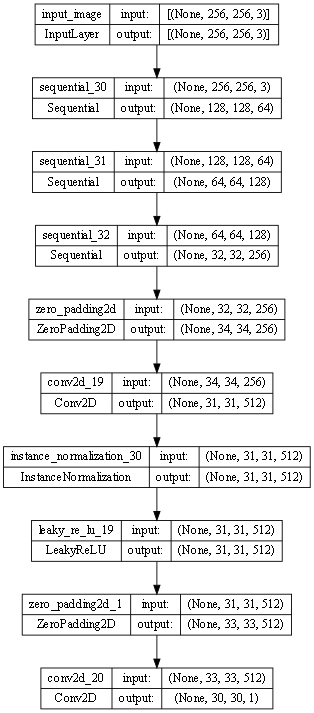

In [30]:
# Arhitektura diskriminatora
tf.keras.utils.plot_model(discriminator_x,to_file="./models/05-cyclegan/diskriminator.png",show_shapes=True,dpi=64)

In [31]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_30 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_31 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_32 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 256)      0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

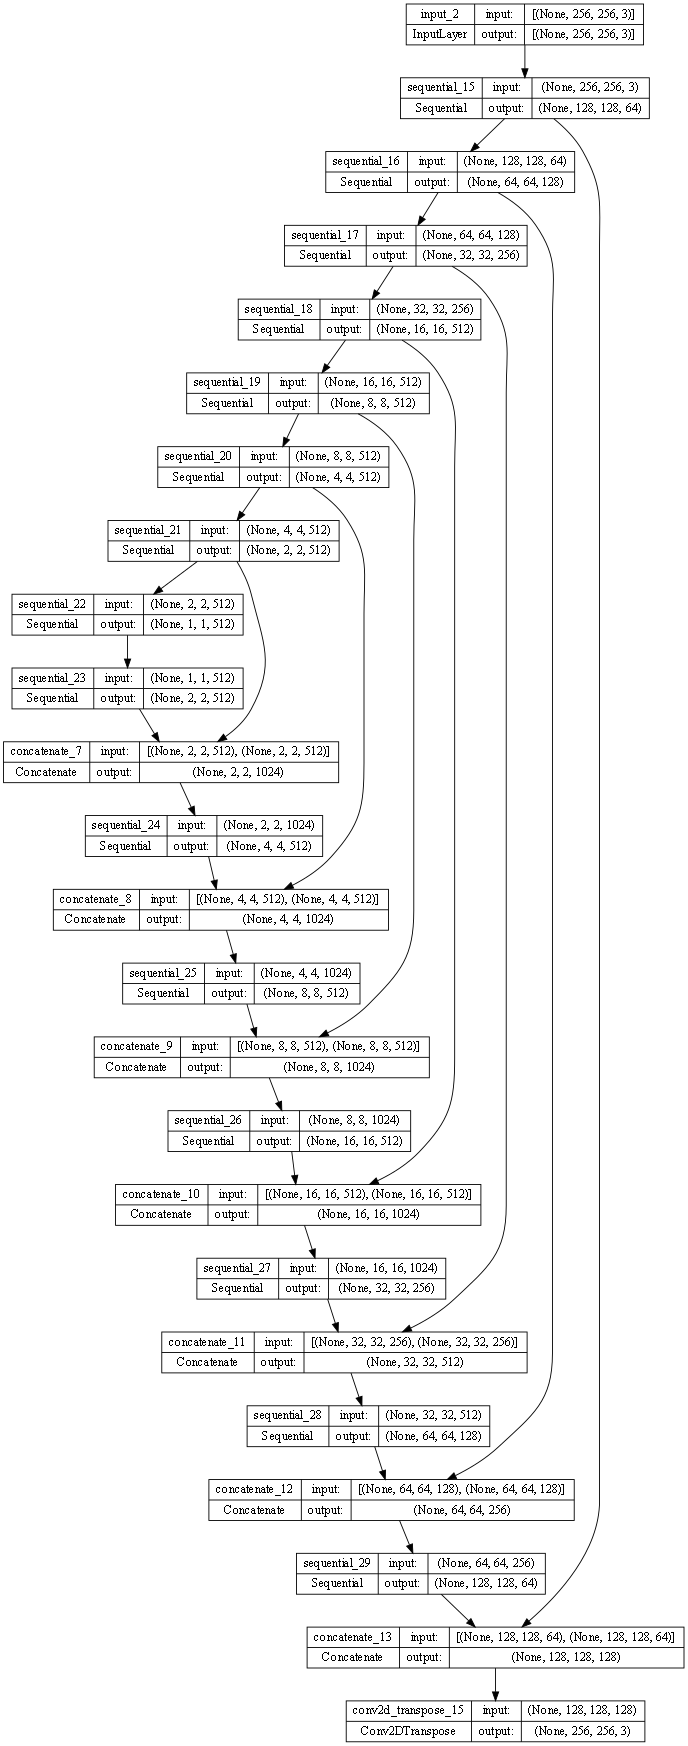

In [32]:
# Arhitektura generatora
tf.keras.utils.plot_model(generator_f,to_file="./models/05-cyclegan/generator.png",show_shapes=True,dpi=64)

In [33]:
generator_f.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_15 (Sequential)     (None, 128, 128, 64  3072        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_16 (Sequential)     (None, 64, 64, 128)  131328      ['sequential_15[0][0]']          
                                                                                            

# Funkcije gubitka
Posto se u CycleGan-u radi sa neuparenim podacima, tj. niko ne garantuje da se ulaz x i cilj y imaju bilo kakvu vezu , zbog toga se koristi cikulsni konzistetni gubitak ( cycle consistency loss)  da bi mreza naucila dobro mapirnje.

In [34]:
LAMBDA = 10

In [35]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [36]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [37]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

Ova funkcija gubitka nam omogucava da resultat transformacije bude slican ulaznim podacima. Naime bez ove funkcije gubitka, generatori bi mogli da nauce mapiranje koje ce sve slike iz jednog skupa slika mapirati u jednu istu sliku koju diskriminator ne bi mogao da kaze da je lazna. Naime ovom funkcijom gubitka sprecavamo generatore da nauce "identicko preslikavanje".
Zelimo da ako G(x) = z, da onda Y(z) bude dovoljno blizu x.
<img src="images/cycle_loss.png"  width="600" hight="600" align="left">

In [38]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

Funkcija gubitka identiteta sluzi da ako koristimo generator G koji mapira skup X u skup Y, na instanci skupa Y, da se generisani rezultat ne razlikuje mnogo od same instance jer sama instanca pripada ciljanoj grupi.
Indentity_loss
<img src="images/Indentity_loss.png"  width="600" hight="600" align="left">

In [39]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [40]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [41]:
checkpoint_path = "./checkpoints/05-cyclegan/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Ako postoji prethodni checkpoint, pokusacemo da ga ucitamo
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Poslednji checkpoint ucitan!!')

In [42]:
EPOCHS = 25

In [43]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Ulazna Slika', 'Generisana Slika']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [44]:
@tf.function
def train_step(real_x, real_y):

    with tf.GradientTape(persistent=True) as tape:
        # Generator G mapira X -> Y
        # Generator F mapira Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y za funkciju gubitka identieta.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # racunjanje gubitka
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Racunajnje ukupne greske generatora
        id_loss_gen_g = identity_loss(real_y, same_y)
        
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Racunanje gradijenata
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
    return total_gen_g_loss, gen_g_loss, id_loss_gen_g , disc_x_loss, total_cycle_loss

In [45]:
total_gen_g_loss_list = []
gen_g_loss_list = []
id_loss_gen_g_list = []
disc_x_loss_list_list= []
total_cycle_loss_list = []

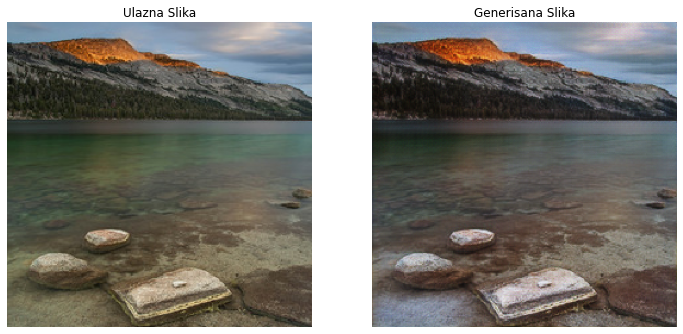

Saving checkpoint for epoch 25 at ./checkpoints/05-cyclegan/train\ckpt-5
Time taken for epoch 25 is 246.04215788841248 sec



In [46]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_datasetA, train_datasetB)):
        total_gen_g_loss, gen_g_loss, id_loss_gen_g , disc_x_loss, total_cycle_loss = train_step(image_x, image_y)
        if n % 100 == 0:
            print ('.', end='')
            gen_g_loss_list.append(gen_g_loss)
            total_gen_g_loss_list.append(total_gen_g_loss)
            id_loss_gen_g_list.append(id_loss_gen_g)
            disc_x_loss_list_list.append(disc_x_loss)
            total_cycle_loss_list.append(total_cycle_loss)
            
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_g, sample_summer)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

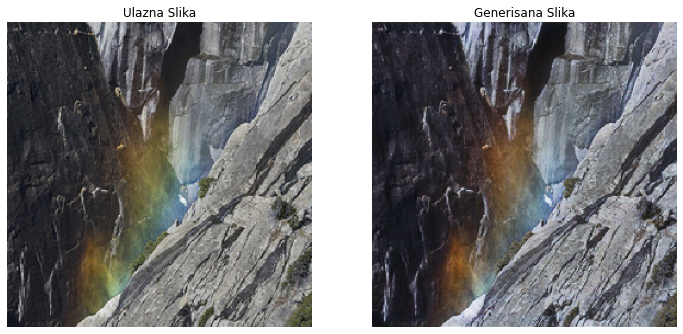

In [47]:
generate_images(generator_g, sample_winter)

Generator F vrsi mapiranje slika zime u slike leta, dok generator G vrsi mapiranje slika leta u slike zime.
U nastavku mozete videti nekoliko primera kako rade ova dva genertora.

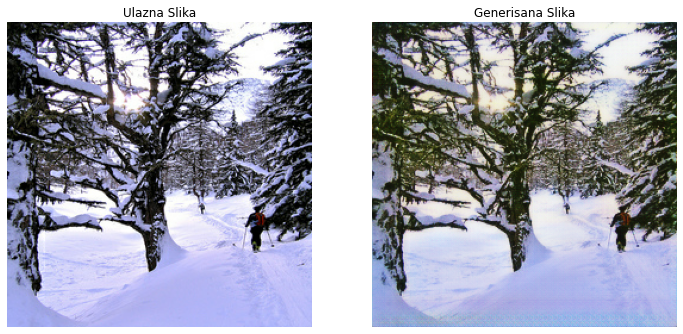

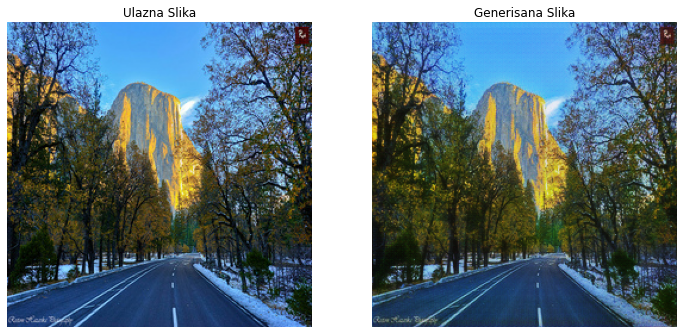

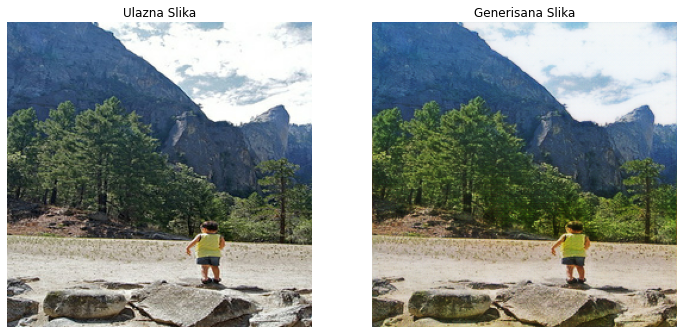

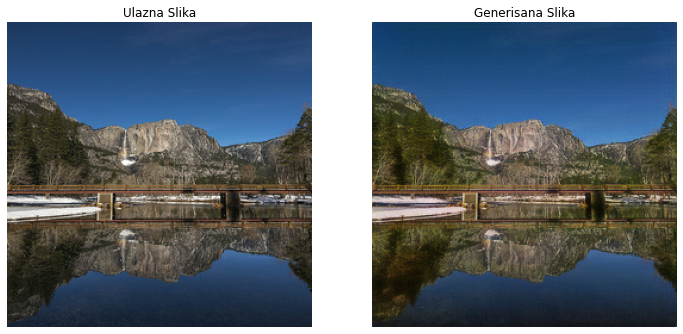

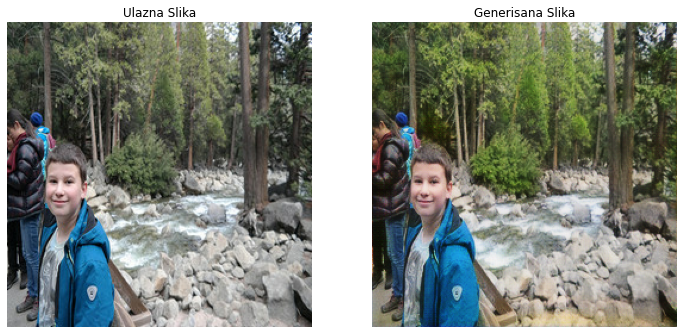

In [48]:
# prebacivanje slika zime u leto
for sample in test_datasetB.take(5):
    generate_images(generator_f, sample)

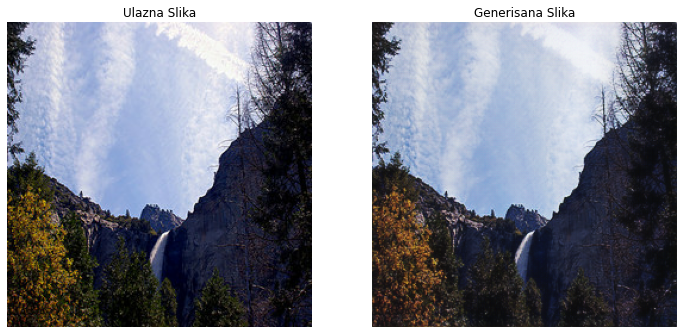

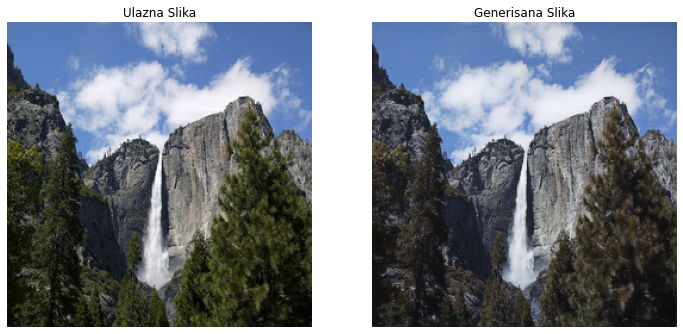

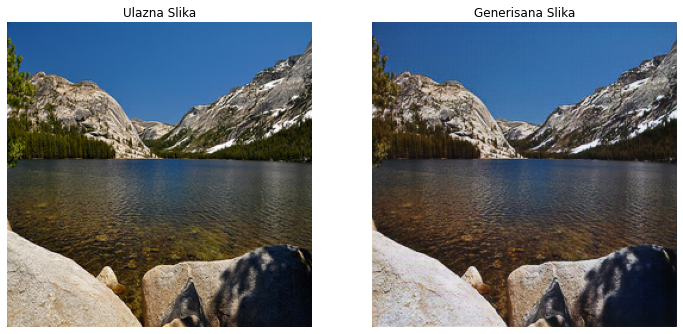

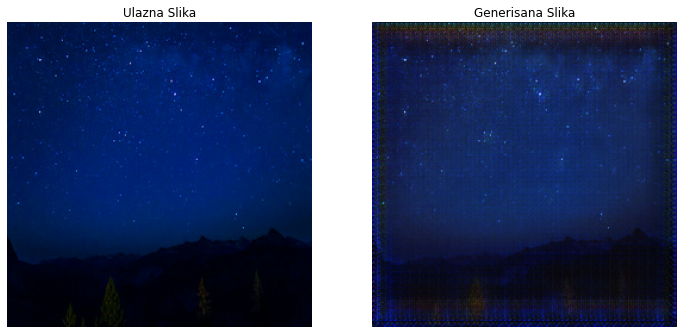

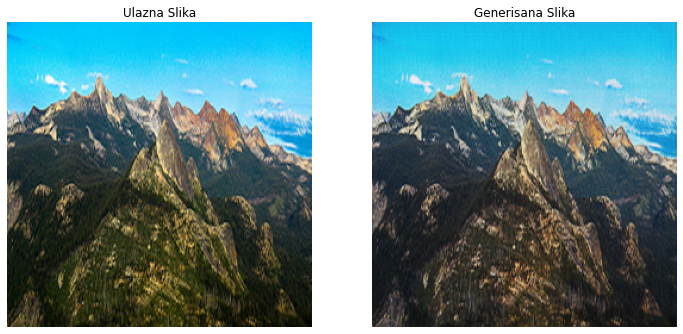

In [49]:
# prebacivanje slika leta u zimu
for sample in test_datasetA.take(5):
    generate_images(generator_g, sample)

Slede grafici funkcija gubitka za generator G. Treba uzeti u obzir da je ovo jako zahtevan problem i da je u radu predlozeno da se obucavanje vrsi na oko 200 epoha da bi se dobili optimalni rezultati.

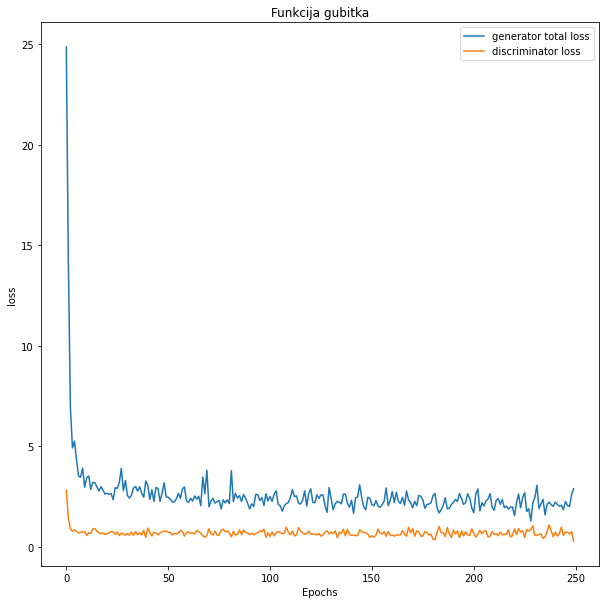

In [50]:
plt.figure(figsize=(10,10))
plt.title('Funkcija gubitka')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(np.arange(0,len(total_gen_g_loss_list)), total_gen_g_loss_list, label='generator total loss')
plt.plot(np.arange(0,len(disc_x_loss_list_list)), disc_x_loss_list_list, label='discriminator loss')
plt.legend(loc='best')
plt.show()

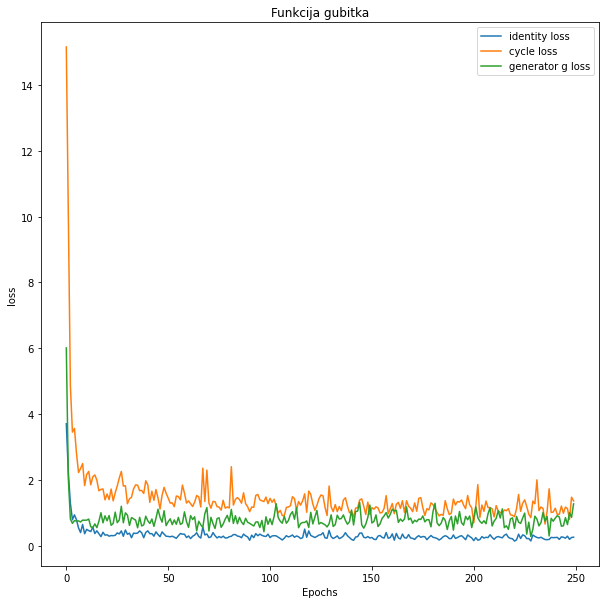

In [51]:
plt.figure(figsize=(10,10))
plt.title('Funkcija gubitka')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(np.arange(0,len(id_loss_gen_g_list)), id_loss_gen_g_list, label='identity loss')
plt.plot(np.arange(0,len(total_cycle_loss_list)), total_cycle_loss_list, label='cycle loss')
plt.plot(np.arange(0,len(gen_g_loss_list)), gen_g_loss_list, label='generator g loss')
plt.legend(loc='best')
plt.show()

In [53]:
# Cuvanje modela za naknadnu upotrebu
generator_g.save('models/05-cyclegan/generator_g.h5')
generator_f.save('models/05-cyclegan/generator_f.h5')

discriminator_x.save('models/05-cyclegan/discriminator_x.h5')
discriminator_y.save('models/05-cyclegan/discriminator_y.h5')